- 내용 및 코드 참조, 출처
  - https://www.tensorflow.org/tutorials/generative/cyclegan
  - https://suanlab.com/suan/
  - https://github.com/22016759/Coding3-Final-Project

# CycleGAN

- 조건부 GAN을 사용하여 페어링되지 않은 이미지 대 이미지 변환

- 한 이미지 도메인의 특성을 캡처하고 이러한 특성을 다른 이미지 도메인으로 변환 할 수있는 방법을 알아낼 수있는 방법을 제안

- Pix2Pix와의 차이는 추가 손실 함수와 페어링되지 않은 훈련 데이터의 사용한다는 점

- CycleGAN은 a cycle consistency loss를 사용하여 쌍을 이루는 데이터 없이도 훈련을 가능하게 함  
  즉, 소스 및 대상 도메인 간의 일대일 매핑없이 한 도메인에서 다른 도메인으로 변환 가능

- 이것은 사진 향상, 이미지 색상 화, 스타일 전송 등과 같은 많은 흥미로운 작업을 수행 할 수있는 가능성을 열어줌  
  필요한 것은 소스와 대상 데이터 세트 (단순히 이미지 디렉토리)뿐임

  <img src="https://www.tensorflow.org/tutorials/generative/images/horse2zebra_1.png">

  <img src="https://www.tensorflow.org/tutorials/generative/images/horse2zebra_2.png">

- Pix2Pix의 generator와 discriminator를 가져올 수 있는 패키지 설치
* https://github.com/tensorflow/examples.git

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# tfds.disable_progress_bar() # 진행 막대 비활성화 옵션
AUTOTUNE = tf.data.AUTOTUNE

## 입력 파이프 라인

- 학습 데이터셋에 랜덤 지터링(random jittering)을 적용

- 이는 과적합을 방지하기 위한 이미지 증강 기법입니다.
- Pix2Pix 모델과 유사한 방식을 사용합니다.

- 랜덤 지터링 과정:
  1. 이미지 크기 조정 및 무작위 자르기
  2. 임의 확률로 이미지를 좌우로 무작위 회전 및 뒤집기 -> 좌우 대칭의 변화에 대한 모델의 강인성을 높이는데 유용함

In [3]:
# 데이터셋 로드 (말과 얼룩말 이미지)
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

# 훈련 및 테스트 데이터셋 분리
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [4]:
# 데이터 처리를 위한 상수 정의
BUFFER_SIZE = 1000 # 셔플 버퍼 크기
BATCH_SIZE = 1 # 배치 크기
IMG_WIDTH = 256 # 이미지 너비
IMG_HEIGHT = 256 # 이미지 높이

In [5]:
# 이미지 무작위 자르기 함수
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

- 이미지 값을 [-1, 1] 사이의 값으로 정규화
  - 이는 모델의 학습을 안정화하고 수렴을 빠르게 하는 데 도움이 됨

In [6]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def random_jitter(image):
  # 286 x 286 크기로 리사이즈
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # 256 x 256 크기로 무작위 자르기
  image = random_crop(image)
  # 50% 확률로 좌우 반전
  image = tf.image.random_flip_left_right(image)

  return image

In [8]:
# 훈련 이미지 전처리 함수
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [9]:
# 테스트 이미지 전처리 함수 (지터링 없음)
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [10]:
# 데이터셋 전처리 및 배치 설정
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
# 샘플 이미지 시각화
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

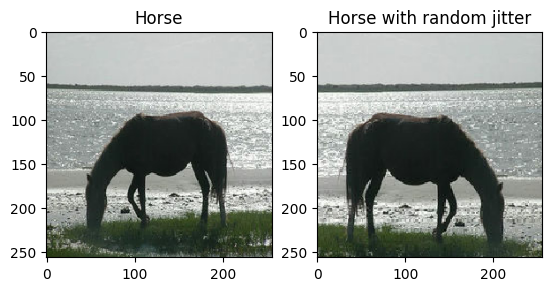

In [12]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

### 모델 아키텍쳐 설명
- CycleGAN은 쌍을 이루지 않는 이미지 간의 변환을 학습합니다.
- 주요 구성 요소: 2개의 생성기(G 및 F)와 2개의 판별자(X 및 Y)
  1. 두 개의 생성자 (G와 F)
  2. 두 개의 판별자 (X와 Y)

생성자의 역할:
  - G: X 도메인의 이미지를 Y 도메인으로 변환 (예: 말 -> 얼룩말)
  - F: Y 도메인의 이미지를 X 도메인으로 변환 (예: 얼룩말 -> 말)

판별자의 역할:
  - D_X: 실제 X 이미지와 생성된 X 이미지(F(Y))를 구별
  - D_Y: 실제 Y 이미지와 생성된 Y 이미지(G(X))를 구별

- 주요 특징
  1. 배치 정규화 대신 인스턴스 정규화 사용
  2. 수정된 U-Net 기반 생성자 사용 (논문의 ResNet 기반과 다름)


  <img src="https://www.tensorflow.org/tutorials/generative/images/cyclegan_model.png">

<img src="https://www.researchgate.net/publication/354884576/figure/fig1/AS:1072924459024391@1632816533652/Diagram-illustrating-the-Pix2Pix-network-architecture.png" width="600">

출처 : Pix2Pix https://www.researchgate.net/figure/Diagram-illustrating-the-Pix2Pix-network-architecture_fig1_354884576

In [13]:
# 출력 채널 수 정의 (RGB 이미지이므로 3)
OUTPUT_CHANNELS = 3
# 생성자 모델 정의
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# 판별자 모델 정의
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

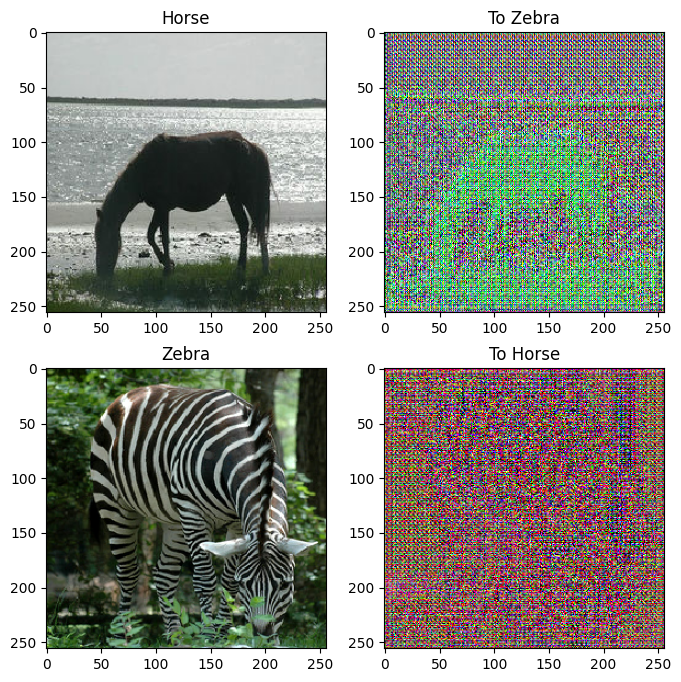

In [14]:
# 샘플 이미지로 생성자 테스트
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)

# 생성된 이미지 시각화
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

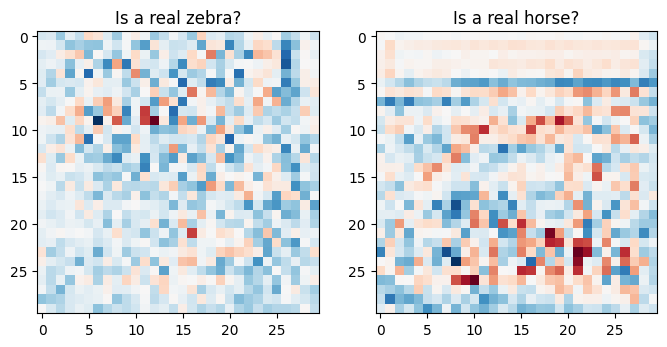

In [15]:
# 판별자 출력 시각화
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 손실 함수 정의

CycleGAN의 특징:
  - 쌍을 이루는 데이터가 없어 입력 x와 목표 y의 직접적인 관계를 학습할 수 없음
  - 이를 해결하기 위해 주기 일관성 손실(cycle consistency loss) 도입

주요 손실 함수:
  1. 판별자 손실: 실제 이미지와 생성된 이미지를 구별하는 능력을 평가
    - 목적: 실제 이미지와 생성된 이미지를 구별하는 능력을 평가
    - 방법: 실제 이미지에는 '1' (진짜), 생성된 이미지에는 '0' (가짜) 라벨을 부여하고, 판별자가 이 두 가지를 얼마나 잘 구별하는지 평가

  2. 생성자 손실: 생성된 이미지가 얼마나 실제처럼 보이는지 평가
    - 목적: 생성된 이미지가 실제 이미지와 얼마나 유사하게 보이는지 평가
    - 방법: 생성된 이미지를 판별자에 입력하여, 판별자가 이 이미지를 실제로 인식하도록 만듭니다. 생성자는 판별자를 속이는 데 성공할수록 더 낮은 손실 값을 얻음
  3. 주기 일관성 손실: 원본 이미지로의 재구성 능력을 평가
    - 목적: 원본 이미지로부터 생성된 이미지를 다시 원본 도메인으로 변환했을 때, 시작 이미지와 최종 이미지가 일치하는지 확인
    - 방법: 이미지 A를 이미지 B로 변환한 후 다시 이미지 A로 변환하고, 원본 이미지 A와 최종 이미지 A를 비교
  4. 아이덴티티 손실: 동일 도메인 내에서의 변환 최소화를 위해 사용
    - 목적: 이미지가 동일 도메인 내에서 변환되었을 때 원본 이미지와 크게 달라지지 않도록 함
    - 방법: 예를 들어, B 도메인의 이미지를 B 도메인으로 변환하는 함수에 입력했을 때, 이미지가 그대로 유지되어야 함

In [16]:
LAMBDA = 10

In [17]:
# 이진 교차 엔트로피 손실 함수 정의
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# 판별자 손실 함수
def discriminator_loss(real, generated):
    #실제 이미지에 대한 손실 계산: 실제 이미지는 1 (진짜)로 라벨링
    real_loss = loss_obj(tf.ones_like(real), real)

    # 생성된 이미지에 대한 손실 계산: 생성된 이미지는 0 (가짜)로 라벨링
    generated_loss = loss_obj(tf.zeros_like(generated), generated)

     # 총 판별자 손실을 계산: 실제 이미지 손실과 생성된 이미지 손실의 합
    total_disc_loss = real_loss + generated_loss  # 두 손실을 합하여 총 손실 계산

    # 최종 손실은 평균을 내어 반환
    return total_disc_loss * 0.5  # 총 손실의 절반을 취함으로써 판별자의 전체적인 손실 평균을 구함

In [19]:
# 생성자 손실 함수
def generator_loss(generated): # 입력 : 판별자 출력 값
  return loss_obj(tf.ones_like(generated), generated)

### 주기 일관성

- 주기 일관성(cycle consistency)은 주로 이미지 또는 텍스트 변환 작업에서 사용되는 개념으로, 입력을 한 형태에서 다른 형태로 변환한 후, 다시 원래의 형태로 복원할 때 입력과 복원된 출력이 일치해야 한다는 원칙을 말합니다. 이는 변환의 품질을 보장하기 위해 사용됩니다.

- 이 개념을 이미지 변환에 적용하면 다음과 같습니다:

  - 이미지 $X$가 주어졌을 때, 생성기 $G$를 사용하여 $X$를 다른 도메인의 이미지 $\hat{Y}$로 변환합니다.
  - 이 변환된 이미지 $\hat{Y}$를 다시 다른 생성기 $F$를 사용하여 원래 도메인의 이미지 $\hat{X}$로 변환합니다.

  - 이때, 원래 이미지 $X$와 순환을 통해 얻은 이미지 $\hat{X}$ 사이의 차이를 최소화하는 것이 목표입니다.
  
  $\quad forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$

  $\quad backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$

  <img src="https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png">

In [20]:
# 원본 이미지와 순환 이미지 사이의 주기 일관성 손실을 계산하는 함수
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

- 위와 같이 $G$ 생성기는 $X$ 이미지를 $Y$ 이미지로 변환

- ID 손실은 $Y$ 이미지를 생성기 $G$ 에 공급하면 실제 이미지 $Y$ 또는 $Y$ 에 가까운 이미지를 생성해야 한다고 말함

- 말에서 zebra-to-horse 모델을 실행하거나 얼룩말에서 horse-to-zebra 모델을 실행하는 경우 이미지에 이미 대상 클래스가 포함되어 있으므로 이미지를 많이 수정해서는 안됨


$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [21]:
def identity_loss(real_image, same_image):
# 원본 이미지와 순환된 이미지 사이의 절대 차이를 평균하여 계산
  loss = tf.reduce_mean(tf.abs(real_image - same_image))

  # 계산된 손실에 일관성 손실 가중치(LAMBDA)를 곱해 최종 손실을 반환
  # 생성자는 여러 손실의 합을 사용하기 때문에 LAMGDA를 이용해 LAMBDA는 손실의 중요도를 조절
  return LAMBDA * 0.5 * loss

- 모든 생성기와 판별기에 대한 옵티마이저 초기화

In [22]:
# 옵티마이저 정의
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 체크 포인트 설정

In [23]:
# 체크포인트 설정
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

# 'max_to_keep=5'는 최대 5개의 최근 체크포인트만 유지한다는 것을 의미합니다.
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 체크포인트가 존재하는 경우, 가장 최근 체크포인트를 복원
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('최신 체크포인트가 복원되었습니다!!')

## 학습

- 논문에서는 `Epochs=200`으로 설정

- 여기서는 `20`으로 설정. 예측이 덜 정확할 수 있음

In [24]:
EPOCHS = 20

In [25]:
def generate_images(model, test_input):
    '''
    모델을 사용하여 입력 이미지로부터 예측 이미지를 생성하고 시각화하는 함수입니다.
    '''
# 모델에 테스트 입력을 넣어 예측 결과를 얻습니다.
    prediction = model(test_input)

    # 시각화를 위해 12x12 크기의 그래프를 설정합니다.
    plt.figure(figsize=(12, 12))

    # 입력 이미지와 예측 이미지를 표시할 목록입니다.
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    # 입력 이미지와 예측 이미지를 순서대로 플롯합니다.
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # 이미지의 픽셀 값을 [0, 1] 범위로 조정하여 표시합니다.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

- 학습 과정
  
  - 예측을 가져옴

  - 손실을 계산

  - 역 전파를 사용하여 기울기를 계산

  - 옵티마이저에 그라디언트를 적용

In [26]:
"""
@tf.function 데코레이터는 파이썬 함수를 TensorFlow 그래프 코드로 변환하여
TensorFlow의 실행 엔진에 의해 최적화되어 더 빠르게 실행될 수 있음.
특히 GPU나 TPU 같은 하드웨어 가속기에서 실행될 때 성능 향상이 두드러짐
"""
@tf.function
def train_step(real_x, real_y):
    # 기본적으로 tf.GradientTape는 그라디언트를 한 번만 계산하도록 설정되어 있어 그라디언트를 계산한 후에는 자동으로 자원을 해제함
    # persistent=True 옵션은 여러 번의 그라디언트 계산 후에도 자동으로 소멸되지 않도록 함
    with tf.GradientTape(persistent=True) as tape:
        # 생성기 G는 X를 Y로 변환합니다.
        # 생성기 F는 Y를 X로 변환합니다.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # 아이덴티티 손실을 위해 same_x와 same_y를 계산합니다.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # 판별자 X와 Y에 대한 실제 이미지의 판별 결과를 계산합니다.
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        # 판별자 X와 Y에 대한 가짜 이미지의 판별 결과를 계산합니다.
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # 손실을 계산합니다.
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # 주기 일관성 손실을 계산합니다.
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # 판별자 X와 Y에 대한 가짜 이미지의 판별 결과를 계산합니다.
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # 손실을 계산합니다.
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # 생성자와 판별자의 그라디언트를 계산합니다.
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

    # 계산된 그라디언트를 적용하여 최적화를 수행합니다.
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

- 학습 소요시간 매우 오래 걸림

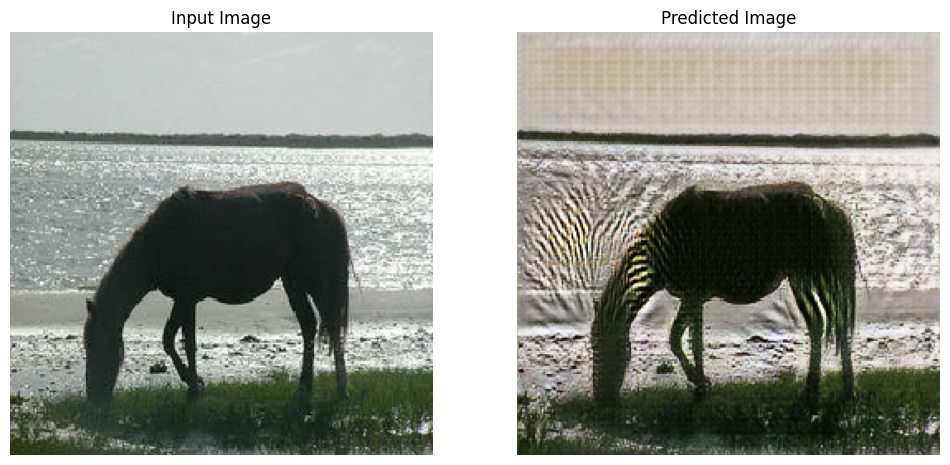

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 508.60575675964355 sec

...................................................................

KeyboardInterrupt: 

In [27]:
for epoch in range(EPOCHS):
    start = time.time() # 에포크 시작 시간을 기록

    # 이미지 쌍을 처리하는 반복 횟수를 추적하기 위한 카운터
    n = 0
    # 훈련 데이터셋을 불러오고, 말 이미지와 얼룩말 이미지 쌍을 하나씩 처리
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        # 10번째 스텝마다 진행 상황을 점으로 표시합니다.
        if n % 10 == 0:
            print('.', end='')
        n += 1
    # 현재 출력을 클리어하고 마지막 출력만 유지하여 노트북의 출력을 깔끔하게 합니다.
    clear_output(wait=True)
    # 일관된 이미지 (sample_horse)를 사용하여 모델의 진행 상황을 명확하게 보여줍니다.
    generate_images(generator_g, sample_horse)

    # 5 epoch마다 체크포인트를 저장합니다.
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('에포크 {}에서 체크포인트 저장, 경로: {}'.format(epoch+1,
                                                                ckpt_save_path))

    print('에포크 {} 완료, 소요 시간: {}초\n'.format(epoch + 1,
                                                      time.time()-start))

## 테스트 데이터셋을 사용하여 생성

In [28]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

Output hidden; open in https://colab.research.google.com to view.